#Step 1: Write your Segmentation Algoirthm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  Your algorithm must be based on thresholding and you should consider doing some region processing after segmentation to improve the result.

_Hint: You'll need to be a bit creative when devising your solution -- no single technique from class is likely to give you a particularly good solution, and you may need to think of some tricks that were not explicitly covered in class.  However, you can get a good result with a fairly simple algorithm.  You'll also need to decide how to handle the fact that the input images are colour, although this shouldn't pose too much of a problem, in fact, it is an advantage!_


In [17]:
import skimage.util as util
import skimage.io as io
import numpy as np
import glob
import scipy.spatial.distance as distance
import skimage.filters as filt
import skimage.morphology as morph
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import mark_boundaries
import os as os
import matplotlib.pyplot as plt
#import cv2
import skimage.color as color

# You can import other modules as needed.

def otsu(I):
    '''
    Finds the optimal threshold of an image
    :param I: Input image to find the threshold
    :return:A tuple of values that minimizes weighted sum of group variances σ^(2)w(t) for the red and green channel
    '''

    #Isolating the colour channels and placing them in bins
    red = 256 * I[:, :, 0]  # Zero out contribution from green
    green = 256 * I[:, :, 1]
    gt = filt.threshold_otsu(green)
    rt = filt.threshold_otsu(red)
    return (gt,rt)

def segleaf(I):
    '''
    Segment a leaf image.
    Use Thresholding. Use region processing after segmentation
    :param I: Color leaf image to segment.
    :return: Boolean image where True pixels represent foreground (i.e. leaf pixels).
    '''

    red = 255 * I[:, :, 0]
    green = 255 * I[:, :, 1]
    blue = 255 * I[:,:,2]
    greenness = 2 * green - red - blue
    T = filt.threshold_otsu(greenness)
    return greenness > T

# Step 2: Implment Measures

Write functions to compute the Mean Squared Distance (MSD), Hausdorff Distance (HD) and Dice Similarity Coefficient (DSC) measures of segmentation quality.  

For MSD and HD, I suggest you reprsent boundaries by N-row, 2-column arrays where each row is the coordinate of one pixel on the region's boundary of the form [r,c], row first, then column.

In [18]:
import skimage.util as util
import skimage.io as io
import numpy as np
import glob
import scipy.spatial.distance as distance
import skimage.filters as filt
import skimage.morphology as morph
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import mark_boundaries
import os as os
import matplotlib.pyplot as plt
#import cv2
import skimage.color as color

def DSC(A,G):
    '''
    Takes a thresholded binary image, and a ground truth img, and computes the Dice Similarity Coeffiencient
    :param A: The thresholded binary image
    :param G: The ground truth img
    :return: The Dice Similarity Coefficient, with numbers close to 1 meaning the two images are nearly identical and numbers close to 0 meaning the two images have little in common
    '''
    #reshape A and G to 1D arrays
    A2 = np.reshape(A, [A.shape[0]*A.shape[1]])
    G2 = np.reshape(G, [G.shape[0]*G.shape[1]])
    sim = aTot = gTot = 0   #sim: the pixels shared by both A and G, aTot: The total true A pix, gTot: the total true G pix
    for reg in range(0,len(A2)):
        #If the two images have this pixel as true
        if A2[reg] == True and G2[reg] == True:
            sim += 1
            aTot += 1
            gTot += 1
        elif A2[reg] == True:
            aTot += 1
        elif G2[reg] == True:
            gTot += 1
    return 2*sim/(aTot + gTot) #Dice similarity coefficient formula

def MSD(A,G):
    '''
    Takes a thresholded binary image, and a ground truth img(binary), and computes the mean squared absolute difference
    :param A: The thresholded binary image
    :param G: The ground truth img
    :return:
    '''
    A_con = np.transpose(np.vstack(np.where(seg.find_boundaries(A==True))))
    G_con = np.transpose(np.vstack(np.where(seg.find_boundaries(G==True))))
    sum = 0
    for aPoint in A_con:
        min = 9999999
        for gPoint in G_con:
            e = ((aPoint[0] - gPoint[0]) + (aPoint[1] - gPoint[1]))**2
            if e < min:
                min = e
        sum += min
    return sum/(A_con.shape[1])



def HS(A,G):
    '''
    :param A:
    :param G:
    :return:
    '''

    A_con = np.transpose(np.vstack(np.where(seg.find_boundaries(A == True))))
    G_con = np.transpose(np.vstack(np.where(seg.find_boundaries(G == True))))
    max1 = 0
    for aPoint in A_con:
        min = 999999
        for gPoint in G_con:
            e = ((aPoint[0] - gPoint[0]) + (aPoint[1] - gPoint[1])) ** 2
            if e < min:
                min = e
        if (min > max1):
            max1 = e
    max2 = 0
    for gPoint in G_con:
        min = 9999999
        for aPoint in A_con:
            e = ((gPoint[0] - aPoint[0]) + (gPoint[1] - aPoint[1])) ** 2
            if e < min:
                min = e
        if (min > max2):
            max2 = e

    return max(max1,max2)

# Step 3: Write a Validation driver program.

Write code that segments each image, and computes the MSD, HD, and DSC for each segmentation.  Print the MSD, HD, and DSC of each segmentation as you perform it.  At the end, print the average and standard deviation of the DSC, the MSD and the HD over all of the images.  Also print the percentage of regions that were "recognized" (see below).  Sample output is in the assignment description document.

The general approach should be, for each input image (in the `images` folder):

* load the image and it's ground truth
* segment the input image - this should be a binary image with a single region (connected component).
* extract the region boundary points from the segmented image and ground truth image; store them in Nx2 arrays as described above (see lecture nodes for an example on how to do this!).
* Compute the MSD and the HD from the two sets of boundary points (using the functions in Step 2).
* Compute the DSC from the segmented image and the ground truth image (using the function from Step 2).
* Determine whether the leaf was "recognized" (a leaf is recognized if it's DSC is greater than 0.6).
* Print the MSD, HD, and DSC to the console (see sample output).

When finished, don't forget to print the average and standard deviation of the DSC for all images, and the percentage of images where the leaf was "recognized".

_Feel free to define additional helper functions for your program if you think it will help._

In [ ]:
import skimage.util as util
import skimage.io as io
import numpy as np
import glob
import scipy.spatial.distance as distance
import skimage.filters as filt
import skimage.morphology as morph
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import mark_boundaries
import os as os
import matplotlib.pyplot as plt
import skimage.color as color
import skimage.segmentation as seg

def Driver():
    print("test")
    images = [os.path.basename(x) for x in glob.glob('images/*.png')]
    avD = 0
    avS = 0
    avH = 0
    length = len(images)
    for i in range(0,length):
        print("test2")
        I = util.img_as_float(io.imread('images/' + images[i]))
        J = util.img_as_bool(io.imread('groundtruth/thresh' + images[i]))
        print("test3")
        A = segleaf(I)
        print("test4")
        dsc = DSC(A, J)
        print("test5")
        msd = MSD(A, J)
        print("test6")
        hs = HS(A, J)
        print(images[i])
        print("DSC: ", dsc)
        print("MSD: ", msd)
        print("HS: ", hs)
        if (dsc > 0.6):
            print("Recognized as a leaf")
        avD += dsc
        avS += msd
        avH += hs
    print("Average DSC: ", avD/length)
    print("Average MSD: ", avS/length)
    print("Average HS: ", avH/length)

Driver()

test
test2
test3
test4


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from uint8 to bool
  .format(dtypeobj_in, dtypeobj_out))


test5
test6
image_0019.png
DSC:  0.9815040686335166
MSD:  616086.5
HS:  283024
Recognized as a leaf
test2
test3
test4
test5
test6
image_0018.png
DSC:  0.8140808344198175
MSD:  28156689.5
HS:  463761
Recognized as a leaf
test2
test3
test4
test5
test6
image_0009.png
DSC:  0.9588769247730697
MSD:  5391177.5
HS:  52441
Recognized as a leaf
test2
test3
test4
test5
test6
image_0078.png
DSC:  0.9055089634744873
MSD:  25924756.5
HS:  874225
Recognized as a leaf
test2
test3
test4
test5
test6
image_0132.png
DSC:  0.733256748249252
MSD:  234617243.0
HS:  627264
Recognized as a leaf
test2
test3
test4
test5


# Step 4:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (There is an example in the lecture notes -- last slide, Topic 6 -- showing how to do this).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from uint8 to bool
  .format(dtypeobj_in, dtypeobj_out))


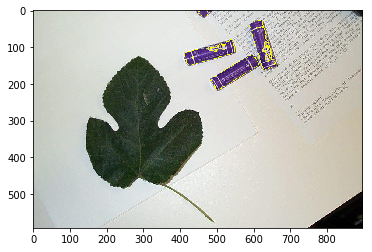

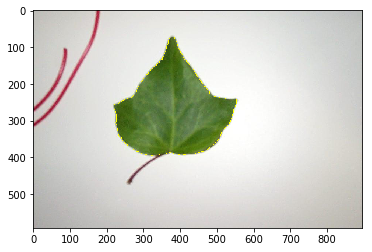

In [8]:
#image_0090.png segments poorly at DSC:  0.23218057880807852
#image_0165.png segments well at DSC:  0.9920585004234908

image = io.imread('images/image_0090.png')
I = util.img_as_float(image)
J = util.img_as_bool(io.imread('groundtruth/threshimage_0090.png'))
A = segleaf(I)
L = morph.label(A, connectivity=2)
boundaries = seg.find_boundaries (L, connectivity=2,mode='inner ')
img_w_b = seg.mark_boundaries(image, L, color=(1 ,1 ,0))
plt.imshow(img_w_b)
plt.show()

image = io.imread('images/image_0165.png')
I = util.img_as_float(image)
J = util.img_as_bool(io.imread('groundtruth/threshimage_0165.png'))
A = segleaf(I)
L = morph.label(A, connectivity=2)
boundaries = seg.find_boundaries(L, connectivity=2,mode='inner ')
img_w_b = seg.mark_boundaries(image, L, color=(1 ,1 ,0))
plt.imshow(img_w_b)
plt.show()

# Step 5: A time for reflection.

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	The segmentation algorithm separates the colour 

2. Consider your good result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	Something is wrong about how my Otsu method is calculating the threshold. It is returning a value that is much higher than expected. This could possibly be casued by incorrect assumptions made about the image, as the channel segments do not really follow a gaussian distribtuions. There are also problems with matrix comparison as true and false values exist in the segmentation but the comparison doesn't work.

3. Consider your bad result.  What is it about your algoirthm caused the poor performance?   If you weren't able to get any results, leave this blank.

	_Your answer:_  


In [ ]:
Driver()